In [0]:
import numpy as np
import matplotlib.pyplot as plt
import string
import csv
import collections


In [665]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Hyperparameters and intitializations

In [0]:
classes = 3
batch_size = 32

# Important functions

In [0]:
def accuracy(preds,true):
  correct = 0
  l = preds.shape[0]
  for ex in range(l):
    if (preds[ex] == true[ex]).all():
      correct+=1
  print(correct, " of", l, "predictions were correct")    
  acc = (correct/l)
  return acc    



def Softmax(logits):
    Max = np.max(logits,axis=1)
    logits= logits- Max.reshape(Max.shape[0],1)
    fin = np.sum(np.exp(logits), axis=1)
    return np.exp(logits) / fin.reshape(fin.shape[0],1)

def cross_entropy_loss(y_true,y_pred):
  return -(y_true * np.log2(y_pred+1e-50)).sum()



# Batch Generator

In [0]:
def data_generator(df,labels,batch_size = 32):

  while True:
    start = 0
    stop = batch_size

    total_batches = int(np.ceil(df.shape[0] / batch_size))

    for i in range(total_batches):
      if i == total_batches-1:
          yield (df[start:,:],labels[start:,:])
      else:        
          yield (df[start:stop,:],labels[start:stop,:])
      start = stop
      stop+= batch_size
  


In [0]:
tweets = []
labels = []

In [0]:
#Loadind the files
with open('/content/drive/My Drive/Tweets.csv') as tw:
  data = csv.reader(tw)
  for row in data:
    labels.append(row[0])
    tweets.append(row[1])

In [0]:
#Converting labels to coded labels

for r in range(len(labels)):
  if labels[r] == 'negative':
    labels[r] = 0
  if labels[r] == 'neutral':
    labels[r] = 1
  if labels[r] == 'positive':
    labels[r] = 2
        

In [0]:
#Deleting the header
tweets = np.asarray(np.delete(tweets,0))
labels = np.asarray(np.delete(labels,0),dtype=int)


# - Dataset Splitting function

In [0]:
def split_data(tweets,labels):

    # Counting total instances of each class
  neg = np.count_nonzero(labels == 0)
  neut = np.count_nonzero(labels == 1)
  pos = np.count_nonzero(labels == 2)

  # Sorting arrays so we can split the data

  sort_indices = np.argsort(labels)
  labels = labels[sort_indices]
  tweets = tweets[sort_indices]

  # Splitting train/test 80-20
  neg_tweets = tweets[0:neg]
  neg_labels = labels[0:neg]
  neut_tweets = tweets[neg:neg+neut]
  neut_labels = labels[neg:neg+neut]
  pos_tweets = tweets[neut+neg:]
  pos_labels = labels[neut+neg:]


  neg_num = int(np.ceil(0.95*neg))
  neut_num = int(np.ceil(0.95*neut))
  pos_num = int(np.ceil(0.95*pos))

  neg_train = neg_tweets[0:neg_num]
  neg_train_l = neg_labels[0:neg_num]

  neg_test = neg_tweets[neg_num:]
  neg_test_l = neg_labels[neg_num:]

  neut_train = neut_tweets[0:neut_num]
  neut_train_l = neut_labels[0:neut_num]

  neut_test = neut_tweets[neut_num:]
  neut_test_l = neut_labels[neut_num:]

                        
  pos_train = pos_tweets[0:pos_num]
  pos_train_l = pos_labels[0:pos_num]

  pos_test = pos_tweets[pos_num:]
  pos_test_l = pos_labels[pos_num:]


  train_data = np.hstack([neg_train,neut_train,pos_train])
  train_labels = np.hstack([neg_train_l,neut_train_l,pos_train_l])
  test_data = np.hstack([neg_test,neut_test,pos_test])
  test_labels = np.hstack([neg_test_l,neut_test_l,pos_test_l])

  # Sanity check
  print(len(train_data)+len(test_data),len(labels))


  #ONE hot
  shape = (train_labels.shape[0],classes)
  encoded = np.zeros(shape)
  rows = np.arange(train_labels.shape[0])
  encoded[rows,train_labels] = 1
  train_labels = encoded


  shape = (test_labels.shape[0],classes)
  encoded = np.zeros(shape)
  rows = np.arange(test_labels.shape[0])
  encoded[rows,test_labels] = 1
  test_labels = encoded

  # Shuffling the data

  index = np.arange(train_labels.shape[0])
  np.random.shuffle(index)
  train_labels = train_labels[index]
  train_data = train_data[index]

  index = np.arange(test_labels.shape[0])
  np.random.shuffle(index)
  test_labels = test_labels[index]
  test_data = test_data[index]


  return train_labels, train_data, test_labels, test_data

# Dataset Preprocessing function

In [0]:
neu_Emo=list(np.unique(('👉,🚪,👀,😔,😊,✈️').split(",")))
pos_Emo=list(np.unique(('💜,✅,💗,💗,💘,💙,✔️,♥,💯,👍,💜✈,😘,⭐️,🙌,😆,😀,😎,👌,❤,💙,💝,😍,💕,😁,😋,👏,🌟,😅,😃,😳,😎,🙉,😻,💔,😜,😄,😆,😜,☀️,😁,😆,🎉,🍷,😀,💁,😂,😉,😮,😲,🎵,🍸,😉,😃,😂,😄,🎲,✌️').split(",")))
neg_Emo=list(np.unique(('❌,🚫,😫,😣,:(,😡,❌,😠,😷,👎,😕,😭,😢,😩,😵,😑,😐,😒,🙏,😤,😡,😖,😩,😞,👿,😥,😒,😷,😑,😩,😏').split(",")))



In [0]:
pos_em = '😁'
neg_em = '😫'
neut_em = '👀'

In [0]:
ignore_list = ["a", "is," "about", "above", "after", "again", "against", "ain", "all", "am", "an", "and", "any", "are", "aren", "aren't", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "can", "couldn", "couldn't", "d", "did", "didn", "didn't", "do", "does", "doesn", "doesn't", "doing", "don", "don't", "down", "during", 'httpt','is','me','amp','hrs','min','via','"',"each", "few", "for", "from", "further", "had", "hadn", "hadn't", "has", "hasn", "hasn't", "have", "haven", "haven't", "having", "he", "her", "here", "hers", "herself", "him", "himself", "his", "how", "i", "if", "in", "into", "is", "isn", "isn't", "it", "it's", "its", "itself", "just", "ll", "m", "ma", "me", "mightn", "mightn't", "more", "most", "mustn", "mustn't", "my", "myself", "needn", "needn't", "no", "nor", "not", "now", "o", "of", "off", "on", "once", "only", "or", "other", "our", "ours", "ourselves", "out", "over", "own", "re", "s", "same", "shan", "shan't", "she", "she's", "should", "should've", "shouldn", "shouldn't", "so", "some", "such", "t", "than", "that", "that'll", "the", "their", "theirs", "them", "themselves", "then", "there", "these", "they", "this", "those", "through", "to", "too", "under", "until", "up", "ve", "very", "was", "wasn", "wasn't", "we", "were", "weren", "weren't", "what", "when", "where", "which", "while", "who", "whom", "why", "will", "with", "won", "won't", "wouldn", "wouldn't", "y", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves", "could", "he'd", "he'll", "he's", "here's", "how's", "i'd", "i'll", "i'm", "i've", "let's", "ought", "she'd", "she'll", "that's", "there's", "they'd", "they'll", "they're", "they've", "we'd", "we'll", "we're", "we've", "what's", "when's", "where's", "who's", "why's", "would",'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'ma', 'mightn', 'mustn', 'needn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn']


In [0]:
def make_dictionary(ignore_list, tweets):
  dictionary = {}

  for i in range(tweets.shape[0]):
    out = tweets[i].replace(',', ' ').replace('.', ' ').replace('!', ' ').replace('?', ' ')
    final = out.translate(str.maketrans('', '', string.punctuation))
    rev = final.split()
    for word in rev:
      if word in ignore_list:
        continue
      elif(any(char.isdigit() for char in word)):
        continue
      if word in pos_Emo:
        word = pos_em
      elif word in neg_Emo:
        word = neg_em
      elif word in neu_Emo:
        word = neut_em
      
      if word in dictionary:
        dictionary[word] +=1
      else:
        word = word.lower()
        dictionary.update({word:1})    
  return dictionary

In [0]:
dictionary = make_dictionary(ignore_list,tweets)


In [0]:
def sort_by_value(dict_obj):
    return collections.OrderedDict(sorted(dict_obj.items(), key=lambda kv: kv[1],reverse=True))

# Extracting features

In [0]:
def matrix_construct(tweets):

  shape = (tweets.shape[0],len(dictionary))
  matrix = np.zeros(shape)
  ones = np.ones((tweets.shape[0],1))
  for i in range(matrix.shape[0]):
    out = tweets[i].replace(',', ' ').replace('.', ' ').replace('!', ' ').replace('?',' ')
    final = out.translate(str.maketrans('', '', string.punctuation))
    rev = final.split()
    for word in rev:
      if word in ignore_list:
        continue
      if(any(char.isdigit() for char in word)):
        continue  
      if word in Pos_Emoji:
        word = pos_em
      elif word in Neg_Emoji:
        word = neg_em
      elif word in Neu_Emoji:
        word = neut_em  
      else:
        word = word.lower()
        if word in dictionary:
          ind = index_list.index(word)
          matrix[i,ind] = dictionary[word]
  # Adding a column of 1s for b0 weight
  matrix = np.hstack([ones,matrix])
  return matrix

# Calling our functions

In [840]:
train_labels, train_data, test_labels, test_data = split_data(tweets,labels)

14640 14640


# K-Fold cross validation data generator

In [0]:
train_matrix = matrix_construct(train_data)
test_matrix = matrix_construct(test_data)

In [0]:
def k_fold_gen(train_matrix,train_labels,split):
  num = int(np.ceil(split*train_matrix.shape[0]))
  folds = int(split*10+1)
  inc = train_matrix.shape[0] - num
  while True:
    start = 0
    stop = inc

    for i in range(folds):

      t_m = np.vstack((train_matrix[0:start,:], train_matrix[stop:,:]))
      t_l =   np.vstack((train_labels[0:start,:], train_labels[stop:,:]))
      v_m = train_matrix[start:stop,:]
      v_l = train_labels[start:stop,:]

      start = stop
      stop += inc
      yield (t_m,t_l,v_m,v_l)


# Weight intitializations

In [0]:
#W = np.random.randn(train_matrix.shape[1]*classes)
W = np.zeros((train_matrix.shape[1],classes))

b = np.zeros(classes).reshape(1,classes)


W = W.reshape(-1,classes)

In [0]:
p = 0.5

In [0]:
W_past = np.zeros_like(W)
V_past = np.zeros_like(W)
beta_1 = 0.99
beta_2 = 0.99

# Starting the training

# Batch Gradient Descent

In [0]:
def batch_gd(train_matrix_split,train_labels_split,epochs,lr,lambd):
  
  J = []
  global W
  global b
  global W_past
  global V_past
  for ech in range(epochs):

# Implementing dropout

    #W_drop = W.copy()
    #mask = np.random.binomial(1, p, size=W_drop.shape) 
    #W_drop[mask] = 0

    logits = (np.dot(train_matrix_split,W) + b) #/p
    
    probs = Softmax(logits)
    loss = cross_entropy_loss(train_labels_split,probs) + (lambd/2)*np.sum(np.square(W))
    loss = loss / train_matrix_split.shape[0]
    J.append(loss)
    # Start computing the gradients

    d_W = np.zeros_like(W)
    d_W = np.dot((probs -  train_labels_split ).T,train_matrix_split).T
    d_b = np.sum(probs - train_labels_split,axis=0)
    d_b = d_b / train_matrix_split.shape[0]
    d_W = d_W / train_matrix_split.shape[0]

    # Updating weights using Adam update
    

    W_past = beta_1 * W_past + (1 - beta_1) * d_W

    V_past = beta_2 * V_past + (1 - beta_2) * np.power(d_W, 2)
    W_hat = W_past / (1 - np.power(beta_1, ech+1))
    V_hat = V_past / (1 - np.power(beta_2, ech+1))
    
    W = W - (lr * W_hat / (np.sqrt(V_hat) + 0.0000001) + (lambd*W)/train_matrix_split.shape[0])
    b = b - lr*d_b
    
  

  predict_tweets(train_matrix_split,train_labels_split)
  predict_tweets(val_matrix,val_labels)
  predict_tweets(test_matrix,test_labels)
  return J


# Mini Batch Gradient descent

In [0]:
def mini_batch_gd(train_matrix_split,train_labels_split,epochs,lr,lambd):
  total_batches = int(np.ceil(train_matrix_split.shape[0] / 1024))
  J = []
  global W
  global W_past
  global V_past
  global b
  train_gen = data_generator(train_matrix_split,train_labels_split,1024)
  for ech in range(epochs):
    for batch in range(total_batches):
      data = next(train_gen)
      #W_drop = W.copy()
      #mask = np.random.binomial(1, p, size=W_drop.shape) 
      #W_drop[mask] = 0
      logits = (np.dot(data[0],W) + b)
    
      #logits = np.dot(data[0],W) + b
      probs = Softmax(logits)
      loss = cross_entropy_loss(data[1],probs) + (lambd/2)*np.sum(np.square(W))
      loss = loss / data[0].shape[0]
      J.append(loss)
      # Start computing the gradients

      d_W = np.zeros_like(W)
      d_W = np.dot((probs - data[1]).T,data[0]).T
      #d_W[mask] = 0
      d_b = np.sum(probs - data[1],axis=0)
      d_b = d_b / data[1].shape[0]
      d_W = d_W / data[0].shape[0]

      # Updating weights
      W_past = beta_1 * W_past + (1 - beta_1) * d_W

      V_past = beta_2 * V_past + (1 - beta_2) * np.power(d_W, 2)
      W_hat = W_past / (1 - np.power(beta_1, ech+1))
      V_hat = V_past / (1 - np.power(beta_2, ech+1))
      W = W - (lr * W_hat / (np.sqrt(V_hat) + 0.00001) + (lambd*W)/data[0].shape[0])

      b = b - lr*d_b
     
  predict_tweets(train_matrix_split,train_labels_split)
  predict_tweets(val_matrix,val_labels)
  predict_tweets(test_matrix,test_labels)    
  return J

In [0]:
dat = k_fold_gen(train_matrix,train_labels,0.99)

In [860]:
train_matrix_split,train_labels_split,val_matrix,val_labels = next(dat)  
    

loss = batch_gd(train_matrix_split,train_labels_split,20,0.0001,0.9999999)

10950  of 13771 predictions were correct
The accuracy on the data is:  0.7951492266356837
108  of 139 predictions were correct
The accuracy on the data is:  0.7769784172661871
534  of 730 predictions were correct
The accuracy on the data is:  0.7315068493150685


In [0]:
W_n = np.random.randn(*W.shape)*0.005
b_n = np.random.randn(*b.shape)*0.005
b += b_n
W +=W_n

In [858]:
a = predict_tweets(test_matrix,test_labels)

523  of 730 predictions were correct
The accuracy on the data is:  0.7164383561643836


In [217]:
loss

[8.91446853889797,
 8.944605583017315,
 8.802120324483507,
 8.881276666921508,
 8.866742574882073,
 8.881878350228027,
 12.022288514477104,
 8.931699280954637,
 8.997153150883795,
 8.864236016059666,
 8.94216455703457,
 8.904137279939826,
 8.938812370082504,
 12.013978881442467,
 8.90441272855758,
 8.9511127129572,
 8.822076816865495,
 8.891568352096243,
 8.837687655228214,
 8.872182842790293,
 11.918160477789419,
 8.834912233626499,
 8.872817321620754,
 8.757679076119274,
 8.822435243937086,
 8.7691391774183,
 8.805759016407809,
 11.824483937046935,
 8.792490258605882,
 8.8279477385999,
 8.71468888976376,
 8.759714533740567,
 8.713815131726129,
 8.735292164273522,
 11.729926144116577,
 8.755086014851939,
 8.789829363336956,
 8.664715522274754,
 8.700992703437489,
 8.660519580330575,
 8.668977491128329,
 11.64417741339023,
 8.715111037324501,
 8.753184474342927,
 8.618638576548769,
 8.652473738755479,
 8.613092400790652,
 8.612616163265992,
 11.567523089770042,
 8.672525256971333,
 8.7

# Checking training & validation accuracy

In [0]:
def predict_tweets(matrix,labels):
  logits = np.dot(matrix,W) + b
  probs = Softmax(logits)
  preds = np.zeros_like(probs)
  index = np.argmax(probs,axis=1).reshape(preds.shape[0],1)
  l = np.arange(len(index)).reshape(preds.shape[0],1)
  preds[l,index] = 1
  acc = accuracy(preds,labels)

  print("The accuracy on the data is: ", acc)
  return preds

In [605]:
# Predicting and calculating accuracy on training data

preds = predict_tweets(train_matrix_split,train_labels_split)


11805  of 13771 predictions were correct
The accuracy on the data is:  0.8572362210442234


In [606]:
# Predicting and calculating accuracy on validation data

preds = predict_tweets(val_matrix,val_labels)


111  of 139 predictions were correct
The accuracy on the data is:  0.7985611510791367


In [607]:
# Predicting and calculating accuracy on test data

predictions = predict_tweets(test_matrix,test_labels)


541  of 730 predictions were correct
The accuracy on the data is:  0.7410958904109589


In [0]:
def predict_tweet(tweet):
  matrix = matrix_construct(tweets)
  logits = np.dot(data[0],W) + b
  probs = Softmax(logits)
  pred = np.argmax(probs,axis=1)
  


# Evaluation metrics

In [0]:
def confusion_matrix(predictions,labels,mat):

  for ind,lab in enumerate(labels):
    tr = np.argmax(lab)
    pr = np.argmax(predictions[ind])
    mat[pr,tr] +=1
  return mat

In [0]:
conf_mat = np.zeros((classes,classes))

In [0]:
c = confusion_matrix(predictions,test_labels, conf_mat)

In [612]:
c.shape

(3, 3)

In [0]:
# Function to extract from confusion matrix

def two_by_two(c,cl):
  mat = np.zeros((2,2))
  t_p = c[cl,cl]
  f_p = np.sum(c[cl]) - t_p
  f_n = np.sum(c[:,cl]) - t_p
  t_n = np.sum(c) - f_p - f_n - t_p
  mat[0,0] = t_p
  mat[0,1] = f_p
  mat[1,0] = f_n
  mat[1,1] = t_n
  return mat

# Evaluation metrics - Macro-Averaging

In [0]:
neg = two_by_two(c,0)
neut = two_by_two(c,1)
pos = two_by_two(c,2)



In [0]:
#mac_recall =  ((neg[0,0]/ np.sum(neg[:,0])) + (neut[0,0]/ np.sum(neut[:,0])) + (pos[0,0])/np.sum(pos[:,0])) / classes


In [0]:

mac_prec =( (neg[0,0]/np.sum(neg[0])) + ( (neut[0,0]) /(np.sum(neut[0]))) + ((pos[0,0]) /np.sum(pos[0])) ) / classes

mac_acc = ( ((np.sum(np.diag(neg))/np.sum(neg)) + (np.sum(np.diag(neut))/np.sum(neut)) + ( np.sum(np.diag(pos))))  /(np.sum(pos)))/ classes

mac_recall = ( (neg[0,0]/ np.sum(neg[:,0])) + (neut[0,0]/np.sum(neut[:,0])) + (pos[0,0])/np.sum(pos[:,0])  ) / classes

mac_f1 = (2*mac_prec*mac_recall)/( mac_prec + mac_recall)

In [616]:
(neg[0,0]/ np.sum(neg[:,0]))

0.8493449781659389

In [617]:
(neut[0,0]/np.sum(neut[:,0]))

0.5324675324675324

In [618]:
(pos[0,0])/np.sum(pos[:,0])

0.5932203389830508

In [619]:
mac_recall

0.6583442832055074

# Evaluation metrics - Micro-Averaging


In [0]:
micro_prec = (neg[0,0] + neut[0,0] + pos[0,0]) / ((neg[0,1] + neut[0,1] + pos[0,1]) + (neg[0,0] + neut[0,0] + pos[0,0]))

micro_acc = (neg[1,1] + neut[1,1] + pos[1,1] +  neg[0,0] + neut[0,0] + pos[0,0]) / (np.sum(neg) + np.sum(neut) + np.sum(pos))

micro_recall = (neg[0,0] + neut[0,0] + pos[0,0]) / (neg[0,0] + neut[0,0] + pos[0,0] +neg[1,0] + neut[1,0] + pos[1,0])

micro_f1 = (2*micro_prec*micro_recall)/ (micro_prec + micro_recall)

In [621]:
micro_acc

0.8273972602739726

# Plots

# Confusion Matrix

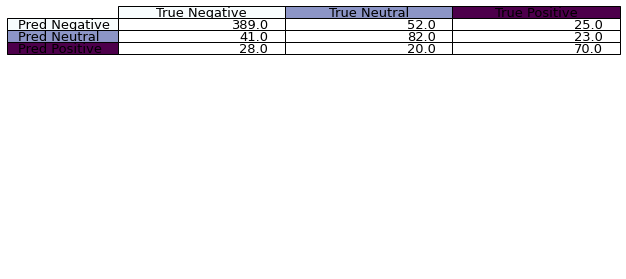

In [622]:

# Prepare table
# Add a table at the bottom of the axes
c_colors = [["w","w","w"],[ "w","w","w"],[ "w","w","w"]]


columns = ('True Negative', 'True Neutral', 'True Positive')
rows = ['Pred Negative', 'Pred Neutral', 'Pred Positive']
# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#c_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#r_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
plt.axis('tight')
plt.axis('off')

cell_text = c
the_table = plt.table(
                      
                      cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      cellColours = c_colors,
                      colColours = colors,
                      colWidths = [0.5,0.5,0.5],
                      colLabels=columns,
                      fontsize = 0.9,
                      loc='top')

the_table.set_fontsize(13)
plt.show()

# Confusion matrix - Class Wise

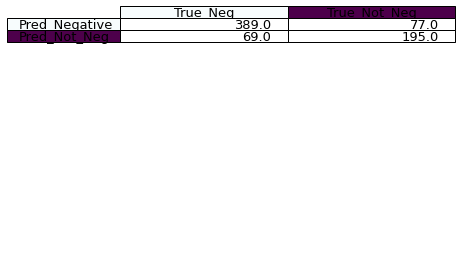

In [623]:

# Prepare table
# Add a table at the bottom of the axes
c_colors = [["w","w"],[ "w","w"]]


columns = ('True_Neg', 'True_Not_Neg')
rows = ['Pred_Negative', 'Pred_Not_Neg']
# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#c_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#r_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
plt.axis('tight')
plt.axis('off')

cell_text = neg
the_table = plt.table(
                      
                      cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      cellColours = c_colors,
                      colColours = colors,
                      colWidths = [0.5,0.5],
                      colLabels=columns,
                      fontsize = 0.9,
                      loc='top')

the_table.set_fontsize(13)
plt.show()

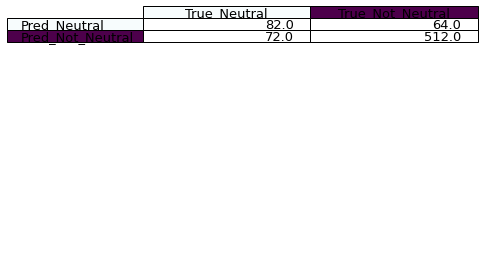

In [624]:

# Prepare table
# Add a table at the bottom of the axes
c_colors = [["w","w"],[ "w","w"]]


columns = ('True_Neutral', 'True_Not_Neutral')
rows = ['Pred_Neutral', 'Pred_Not_Neutral']
# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#c_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#r_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
plt.axis('tight')
plt.axis('off')

cell_text = neut
the_table = plt.table(
                      
                      cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      cellColours = c_colors,
                      colColours = colors,
                      colWidths = [0.5,0.5],
                      colLabels=columns,
                      fontsize = 0.9,
                      loc='top')

the_table.set_fontsize(13)
plt.show()

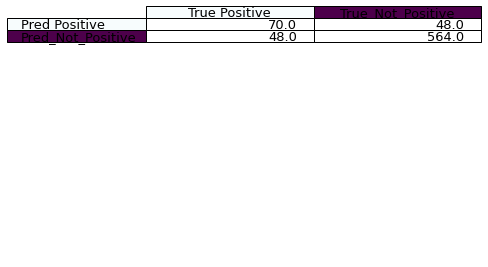

In [625]:

# Prepare table
# Add a table at the bottom of the axes
c_colors = [["w","w"],[ "w","w"]]


columns = ('True Positive', 'True_Not_Positive')
rows = ['Pred Positive', 'Pred_Not_Positive']
# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#c_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#r_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
plt.axis('tight')
plt.axis('off')

cell_text = pos
the_table = plt.table(
                      
                      cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      cellColours = c_colors,
                      colColours = colors,
                      colWidths = [0.5,0.5],
                      colLabels=columns,
                      fontsize = 0.9,
                      loc='top')

the_table.set_fontsize(13)
plt.show()

# Plotting the metrics

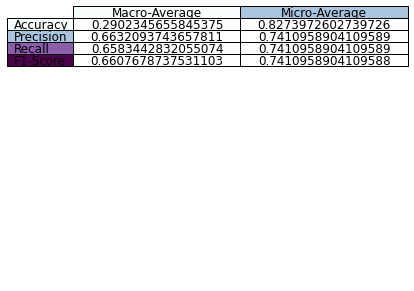

In [626]:

# Prepare table
# Add a table at the bottom of the axes
c_colors = np.asarray(["w","w","w","w", "w","w","w","w"]).reshape(4,2)


columns = ('Macro-Average', 'Micro-Average')
rows = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#c_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
#r_colors = plt.cm.BuPu(np.linspace(0, 1, len(rows)))
plt.axis('tight')
plt.axis('off')

cell_text = np.asarray([mac_acc,micro_acc,mac_prec,micro_prec,mac_recall, micro_recall ,mac_f1,micro_f1]).reshape(4,2)
the_table = plt.table(
                      
                      cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      cellColours = c_colors,
                      colColours = colors,
                      colWidths = [0.5,0.5],
                      colLabels=columns,
                      fontsize = 0.9,
                      loc='top')

the_table.set_fontsize(13)
plt.show()